In [2]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
License(s): CC0-1.0
  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 27.6MB/s]


In [3]:
!unzip daily-climate-time-series-data.zip

Archive:  daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')

In [5]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [7]:
df_train.isna().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [8]:
df_test.isna().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [9]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

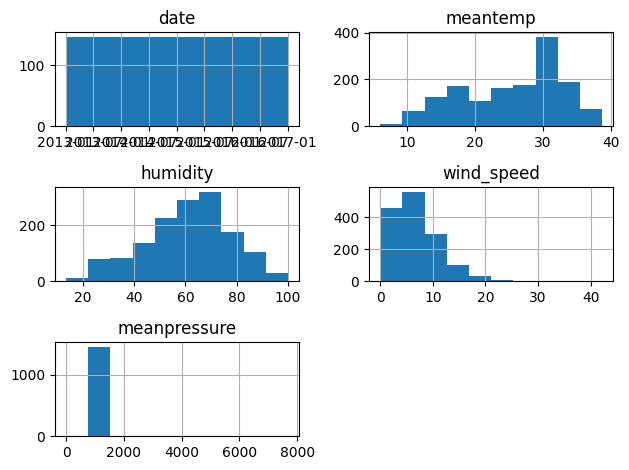

In [10]:
df_train.hist()
plt.tight_layout()
plt.show()

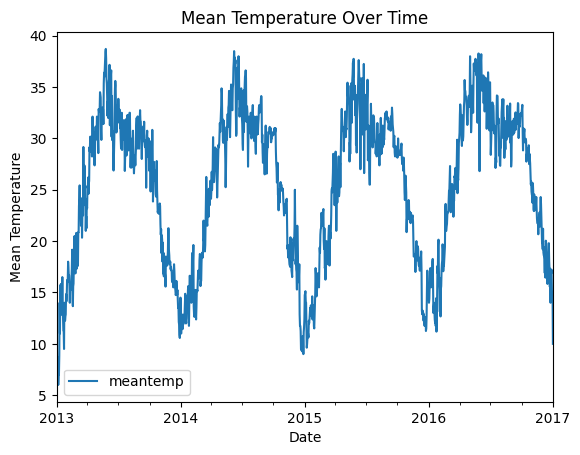

In [11]:
df_train.plot(x='date', y='meantemp')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Over Time')
plt.show()

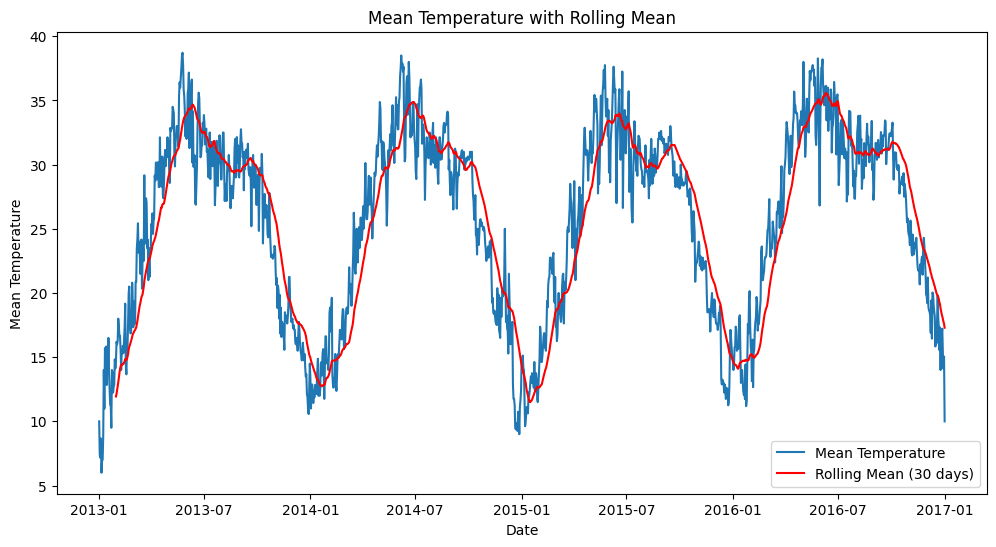

In [12]:
# prompt: identify trends using rolling() function

import matplotlib.pyplot as plt
# Calculate the rolling mean of meantemp with a window of 7 days
df_train['rolling_mean_temp'] = df_train['meantemp'].rolling(window=30).mean()

# Plot the original meantemp and the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['meantemp'], label='Mean Temperature')
plt.plot(df_train['date'], df_train['rolling_mean_temp'], label='Rolling Mean (30 days)', color='red')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature with Rolling Mean')
plt.legend()
plt.show()


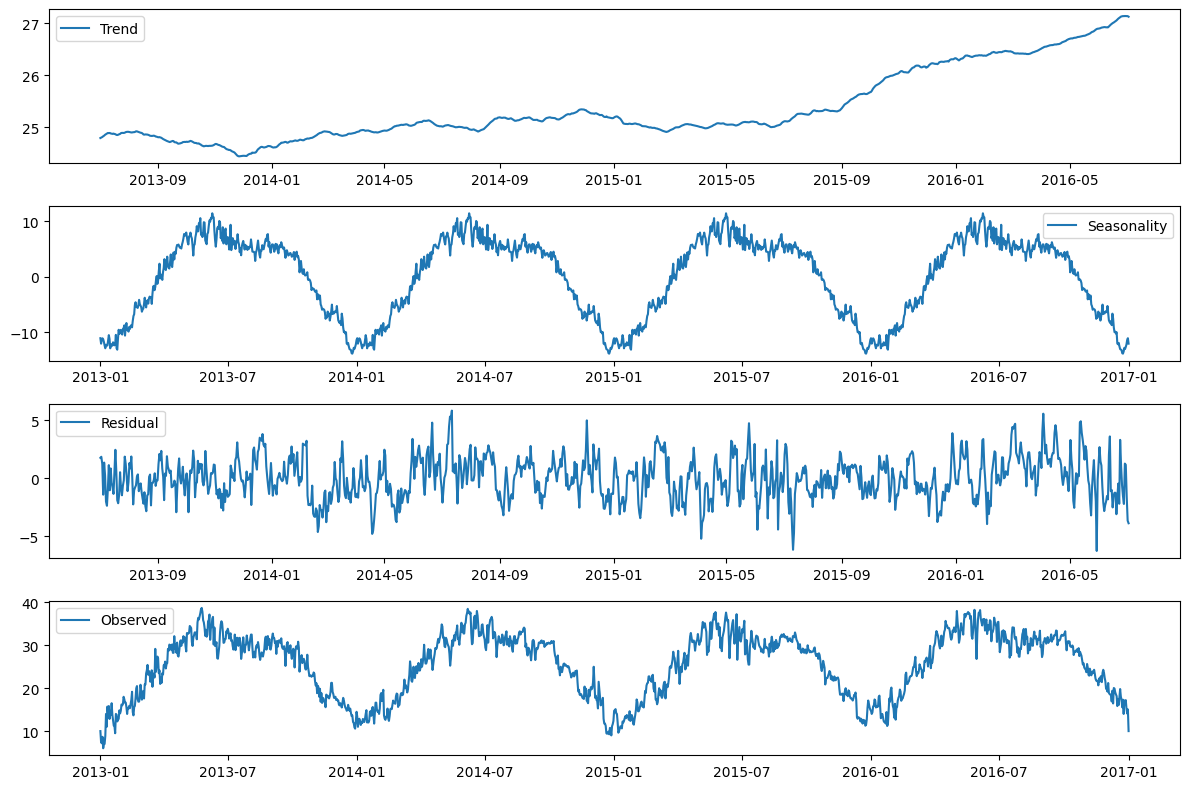

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'meantemp' time series
decomposition = seasonal_decompose(df_train['meantemp'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_train['date'], decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df_train['date'], decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df_train['date'], decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df_train['date'], decomposition.observed, label='Observed')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Trend - Clearly an upward trend of temps, accelerating from 2015-09.

Seasonality - We can see the yearly patterns of temp increases and decreases with the seasons


<Figure size 1200x600 with 0 Axes>

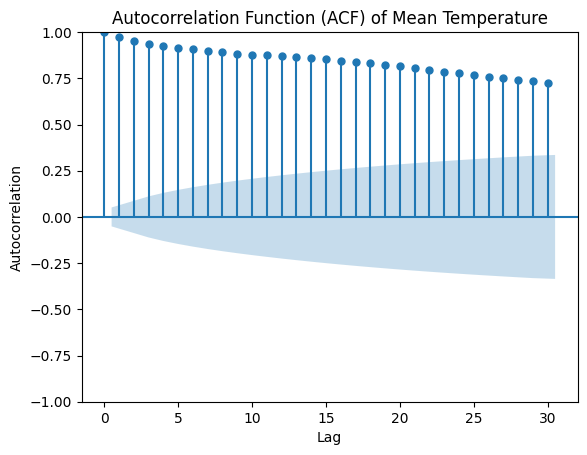

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

# Perform autocorrelation analysis on 'meantemp'
plt.figure(figsize=(12, 6))
plot_acf(df_train['meantemp'], lags=30)  # Adjust the number of lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Mean Temperature')
plt.show()


There is a high correlation at early lags which suggests that the mean temperature is highly correlated over a short-period.

The autocorrelation slope decreases gradually which shows there is some trend or seasonality present. It doesn't drop to zero though so there is a persistent pattern that stretches over many periods.

Overall, this indicates that the mean temperature data has a significant degree of autocorrelation over time, likely due to natural trends such as daily or seasonal temperature cycles.

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(5, 0, 2)   Log Likelihood               -2767.398
Date:                Thu, 10 Oct 2024   AIC                           5552.796
Time:                        20:47:18   BIC                           5600.384
Sample:                             0   HQIC                          5570.547
                               - 1462                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.9793      3.822      5.751      0.000      14.489      29.470
ar.L1          0.5866      0.187      3.131      0.002       0.219       0.954
ar.L2          0.8698      0.251      3.466      0.0

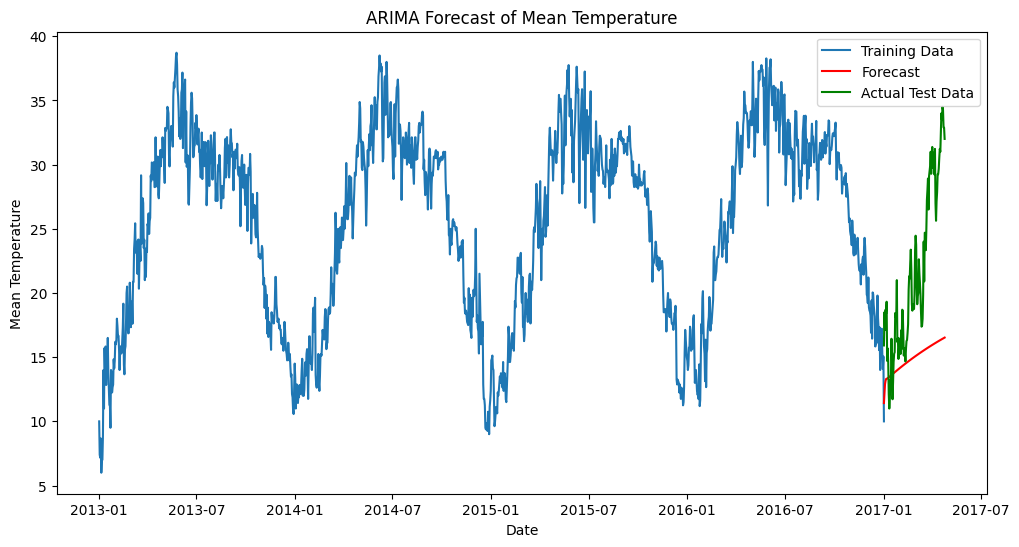

In [30]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Prepare the data for modeling
train_data = df_train['meantemp']

# Fit an ARIMA model
# You might need to experiment with different (p, d, q) orders to find the best fit
model = ARIMA(train_data, order=(5, 0, 2) )
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Forecast future values
forecast_steps = len(df_test)  # Forecast for the length of the test dataset
forecast = model_fit.forecast(steps=forecast_steps)

# Evaluate the model (if you have actual test data)
mse = mean_squared_error(df_test['meantemp'], forecast)
print('Mean Squared Error:', mse)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], train_data, label='Training Data')
plt.plot(df_test['date'], forecast, label='Forecast', color='red')
# If you have actual test data, uncomment the next line
plt.plot(df_test['date'], df_test['meantemp'], label='Actual Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('ARIMA Forecast of Mean Temperature')
plt.legend()
plt.show()
